In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time

In [3]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [20]:
dateparse = lambda dates: pd.datetime.strptime(dates[:19], '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('event-api-request-count.csv', parse_dates=['timestamp'], index_col='timestamp',date_parser=dateparse)
print(data.head())

                     request count
timestamp                         
2017-10-25 00:00:00       120737.0
2017-10-25 00:01:00       122841.0
2017-10-25 00:02:00       123191.0
2017-10-25 00:03:00       126607.0
2017-10-25 00:04:00       126193.0


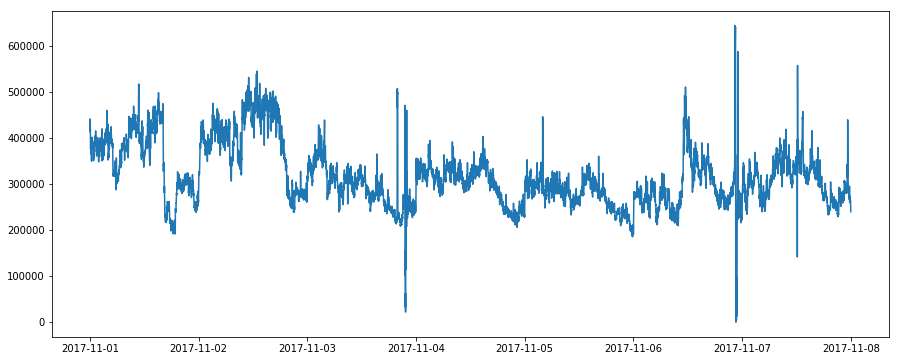

In [61]:
plt.plot(data['request count'])

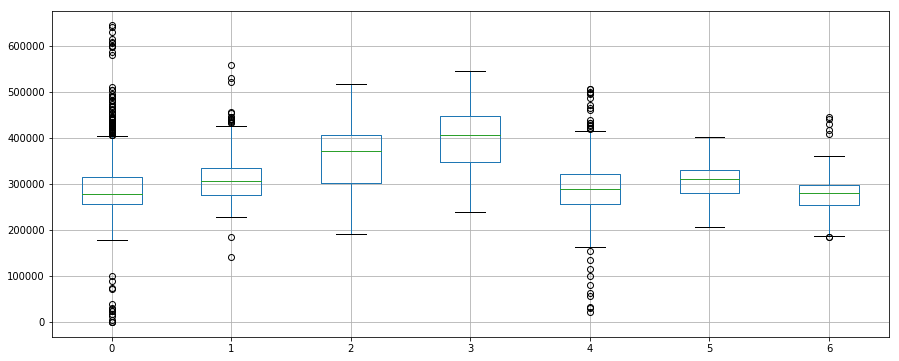

In [22]:
# remove data when cluster was receiving decreased load
data = data[data.index > '2017-11-01 00:00:00']

# plot box plot
box_data = data
box_data['dates'] = data.index
box_data['days'] = data.index.weekday
x =box_data.pivot(index='dates', columns='days', values='request count')
x.boxplot()

In [40]:
# choose an hour of data
train = data[ (data.index > '2017-11-07 18:00:00') & (data.index <= '2017-11-07 19:00:00')]
ts = train['request count']

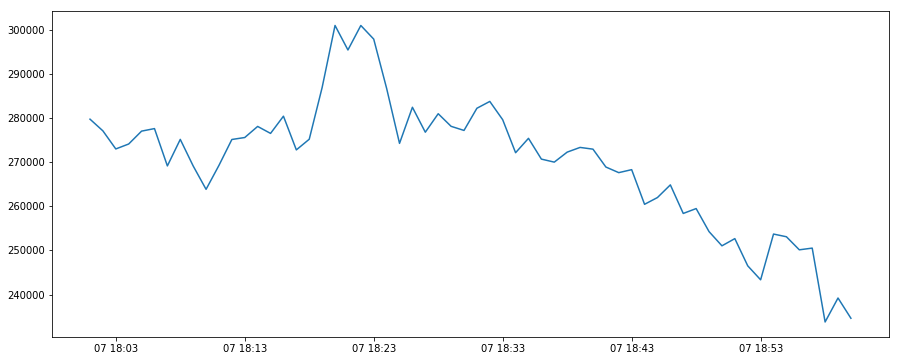

In [41]:
plt.plot(ts)

In [42]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(ts):
    
    #Determing rolling statistics
    rolmean = ts.rolling(center=False,window=5).mean()
    rolstd = ts.rolling(center=False,window=5).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

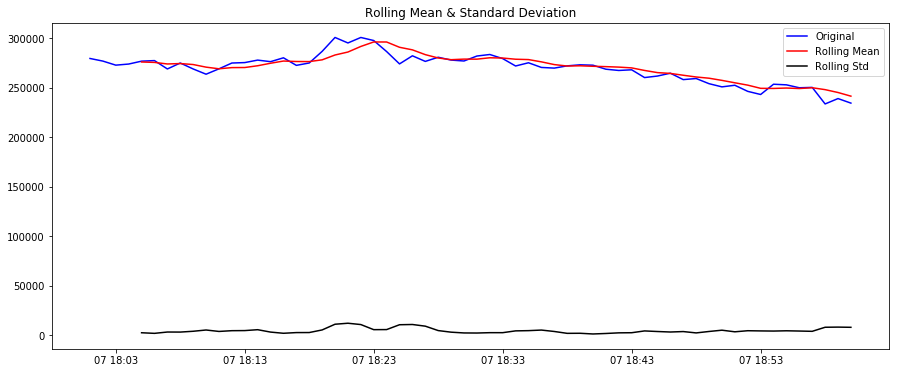

Results of Dickey-Fuller Test:
Test Statistic                 -0.608001
p-value                         0.869164
#Lags Used                      0.000000
Number of Observations Used    59.000000
Critical Value (5%)            -2.911939
Critical Value (1%)            -3.546395
Critical Value (10%)           -2.593652
dtype: float64


In [43]:
test_stationarity(ts)

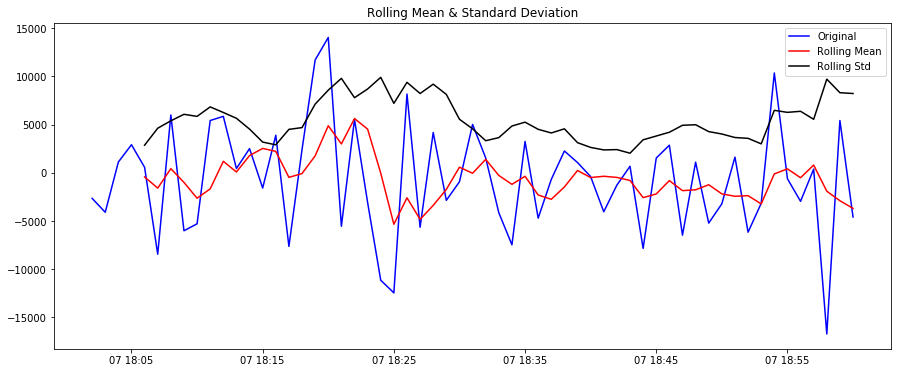

Results of Dickey-Fuller Test:
Test Statistic                -8.532500e+00
p-value                        1.028647e-13
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (5%)           -2.912837e+00
Critical Value (1%)           -3.548494e+00
Critical Value (10%)          -2.594129e+00
dtype: float64


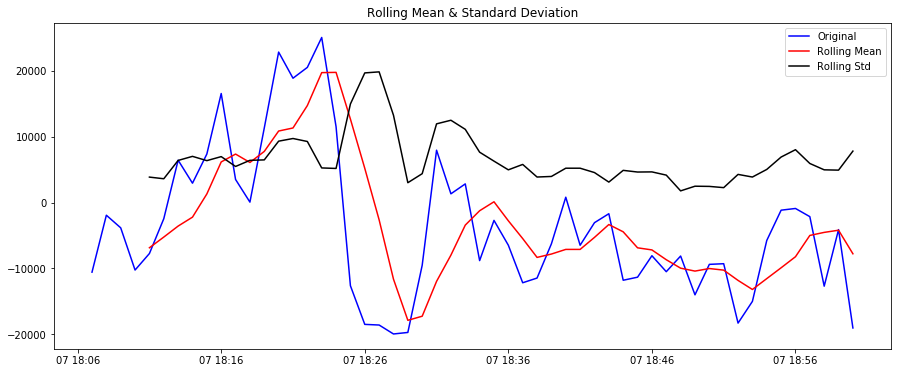

Results of Dickey-Fuller Test:
Test Statistic                 -2.571225
p-value                         0.099092
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (5%)            -2.917850
Critical Value (1%)            -3.560242
Critical Value (10%)           -2.596796
dtype: float64


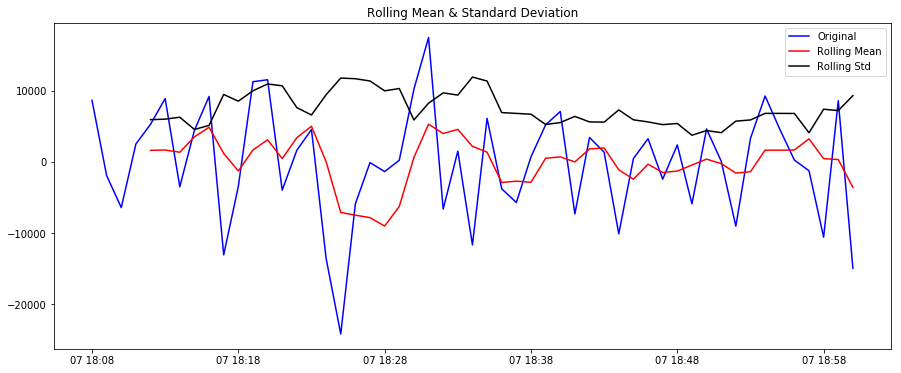

Results of Dickey-Fuller Test:
Test Statistic                -5.649002e+00
p-value                        9.960176e-07
#Lags Used                     5.000000e+00
Number of Observations Used    4.700000e+01
Critical Value (5%)           -2.925338e+00
Critical Value (1%)           -3.577848e+00
Critical Value (10%)          -2.600774e+00
dtype: float64


In [44]:
new_ts = pd.DataFrame()
new_ts['first_difference'] = ts - ts.shift(1)
test_stationarity(new_ts['first_difference'].dropna(inplace=False))

new_ts['seasonal_difference'] = ts - ts.shift(6)
test_stationarity(new_ts['seasonal_difference'].dropna(inplace=False))

new_ts['seasonal_first_difference'] = new_ts['first_difference'] - new_ts['first_difference'].shift(6)
test_stationarity(new_ts['seasonal_first_difference'].dropna(inplace=False))

new_ts['seasonal_first_difference'] = new_ts['seasonal_first_difference'].dropna()

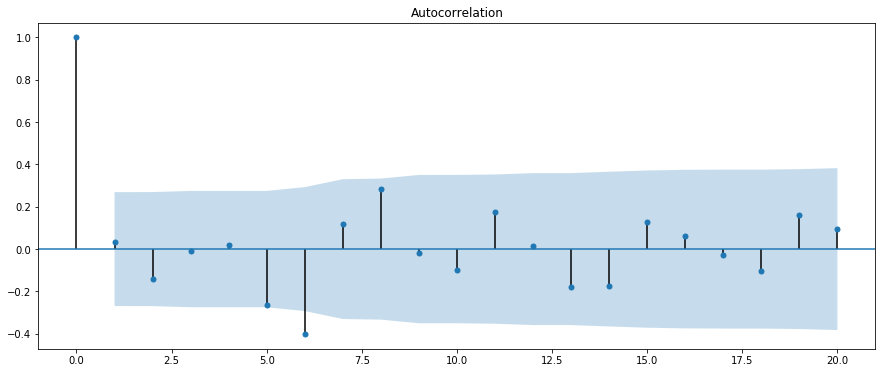

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_acf(new_ts['seasonal_first_difference'].iloc[7:], lags=20)

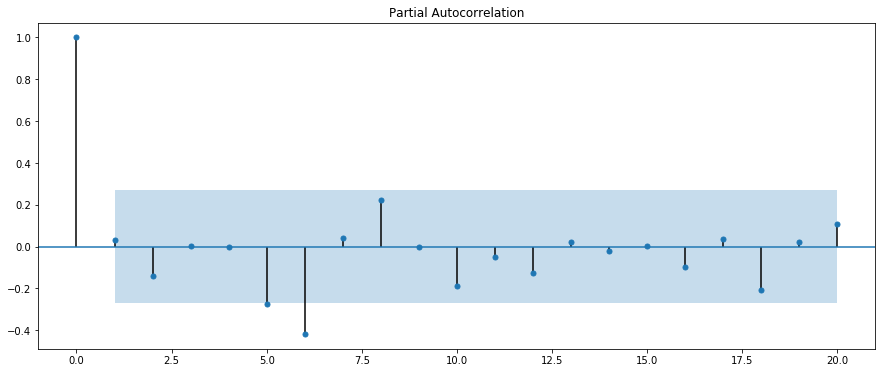

In [31]:
_ = plot_pacf(new_ts['seasonal_first_difference'].iloc[7:], lags=20)

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(ts, order=(0,1,0), seasonal_order=(0,1,1,6))
results = mod.fit()
print(results.summary())


                                 Statespace Model Results                                
Dep. Variable:                     request count   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 6)   Log Likelihood                -550.651
Date:                           Thu, 09 Nov 2017   AIC                           1105.302
Time:                                   09:39:00   BIC                           1109.491
Sample:                               11-07-2017   HQIC                          1106.941
                                    - 11-07-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L6       -0.0563      0.026     -2.164      0.030      -0.107      -0.005
sigma2      4.001e+07   3.53e-11   1.13e+18

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(ts, order=(0,1,0), seasonal_order=(1,1,1,6))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                     request count   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 6)   Log Likelihood                -550.790
Date:                           Thu, 09 Nov 2017   AIC                           1107.580
Time:                                   09:39:12   BIC                           1113.863
Sample:                               11-07-2017   HQIC                          1110.038
                                    - 11-07-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6        0.4700      0.185      2.536      0.011       0.107       0.833
ma.S.L6       -0.5736      0.171     -3.351

In [35]:
real = data[ (data.index >= '2017-11-07 19:00:00') & (data.index < '2017-11-07 19:10:00')]['request count']

In [53]:
pd.options.mode.chained_assignment = None
train['forecast'] = results.predict(start = 50, end= 60, dynamic= True)  

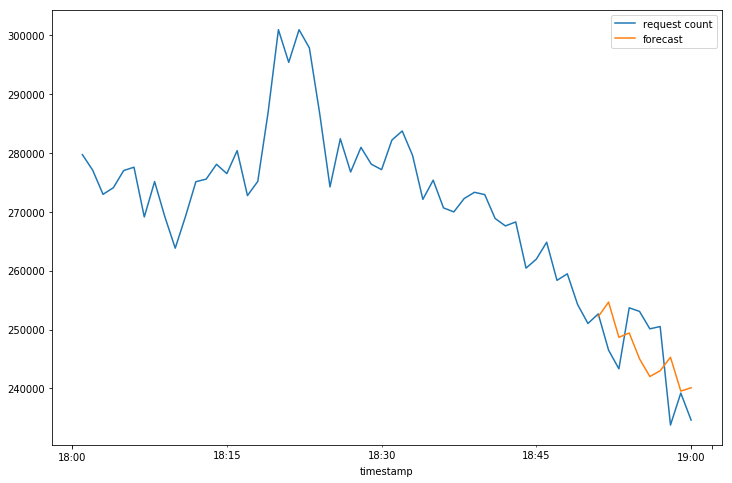

In [54]:
train[['request count', 'forecast']].plot(figsize=(12, 8))

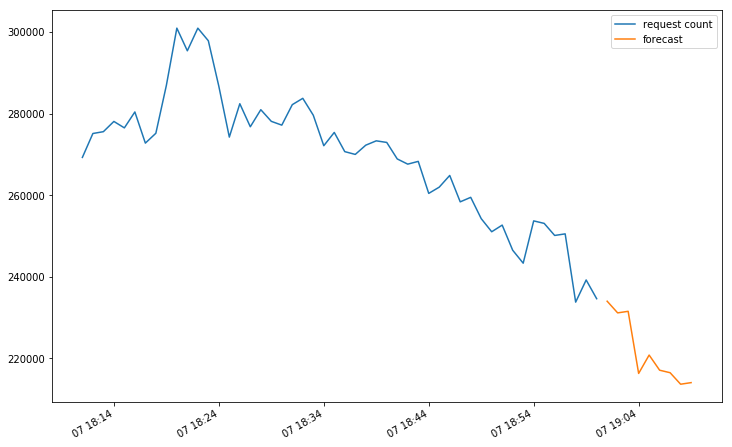

In [60]:
from datetime import date
from datetime import datetime
from datetime import timedelta

start = datetime.strptime('2017-11-07 19:00:00', '%Y-%m-%d %H:%M:%S')
date_list = [start + timedelta(minutes=i) for i in range(0,10)]
future = pd.DataFrame(index=date_list, columns=train.columns)
train = pd.concat([train, future])

train['forecast'] = results.predict(start = 60, end= 70, dynamic= True) 
train[['request count', 'forecast']].iloc[-60:].plot(figsize=(12, 8)) 